# Script for plotting Radiation patterns of various type of Uniform and Non-Uniform Linear Antenna Arrays

### The different configurations taken into consideration are Uniform Array, Binomial Array, Dolph Chebyshev Array and Edge Array.

### The variable parameters are-

### 1) N - Number of Antennas in Array
### 2) λ - Wavelength
### 3) d - Distance between adjecent antennas
### 4) R - Major to minor lobe ratio for Dolph Chebyshev antenna


In [25]:
def SetParameters():
    
    lambd = float(input("Enter value of "+'\u03bb'+": "))
    
    d_in_term_of_lambd = float(input("Enter d in terms of "+'\u03bb'+": "))
    
    d= d_in_term_of_lambd*lambd
    
    beta = 2*np.pi/lambd
    
    dr = beta*d
    
    theta = np.linspace(0,2*np.pi,100000)
    
    psi = dr*np.cos(theta)
    
    return lambd,d,beta, dr, theta, psi
    

def VariableParam():
    
    N = int(input("Enter total number of Array Elements: "))
    
    flag = N%2                                                   # flag=1 => odd elements, flag=0 => even elements

    R = int(input("Enter desired Major to minor lobe ratio in db: "))
    
    R = math.pow(10,R/20)
    
    deg = N-1
    
    x0 = 0.5*(math.pow( R + math.pow((R**2)-1,0.5),1/deg) + math.pow( R - math.pow((R**2)-1,0.5),1/deg) )

    return N,R,flag


def CalculateArguments(flag,N):
    
    arg = []
    
    M = int(N/2)


    if flag:                                      # odd elements

        for i in range(1,M+2):

            arg.append(2*(i-1))         

    else:                                        # even elements

        for i in range(1,M+1):

            arg.append(2*i-1)
            
    
    return arg


def chebyshev(deg,N):
    
    arr = []
    
    for i in range(deg+1):
        
        if i==deg:
            arr.append(1)
        else:
            arr.append(0)
            
    arr = tuple(arr)

    cheb = np.polynomial.chebyshev.Chebyshev(arr)
    coef = np.polynomial.chebyshev.cheb2poly(cheb.coef)
    
    
    for i in range(N-1-deg):
        coef = np.append(coef,0) 
        
    coef = coef.reshape((N,1))
    
    return coef


def CalculateLhsAndRhs(arg,N,x0):
    
    x = []     

    for i in range(len(arg)):

        x.append(chebyshev(arg[i],N))

    lhs = np.transpose(x)[0]

    rhs = chebyshev(N-1,N).reshape((1,N))[0]

    
    for i in range(len(rhs)):
    
        rhs[i] = rhs[i]*(x0**i)
    
    
    return lhs,rhs


def correct_it(arr1,arr2,flag):
    
    if(flag):
        
        i=0
        
        ret1 = []
        ret2 = []
        
        while(i<arr1.shape[0]):
            
            ret1.append(arr1[i])
            ret2.append(arr2[i])
            i = i+2
            
        return ret1,ret2
    
    else:
        
        i=1
        
        ret1 = []
        ret2 = []
        
        while(i<arr1.shape[0]):
            
            ret1.append(arr1[i])
            ret2.append(arr2[i])
            i = i+2
            
        return ret1,ret2

    
def UniformCoefficients(N):
    
    coef= []
    
    flag = N%2
    
    for i in range(int(N/2)+flag):
        
        coef.append(1)
        
    return coef 


def EdgeCoefficients(N):
    
    coef= []
    
    flag = N%2
    
    for i in range(int(N/2)+flag):
        
        if (i == int(N/2)+flag-1) :
            
            coef.append(1)

            break
        
        coef.append(0)
        
    return coef


def BinomialCoefficients(N):
    
    
    coef = []
      
    for i in range(N):
        
        coef.append(scipy.special.binom(N-1,i))
        
    flag = N%2


    coef = coef[:int(N/2)+flag][::-1]
    
    cmax = np.max(coef)
    
    for i in range(len(coef)):
        
        coef[i] = coef[i]/cmax
        
        
    return coef


def ChebCoefficients(N,R,arg,flag):

    
    deg = N-1
    
    x0 = 0.5*(math.pow( R + math.pow((R**2)-1,0.5),1/deg) + math.pow( R - math.pow((R**2)-1,0.5),1/deg) )
    
    lhs, rhs = CalculateLhsAndRhs(arg,N,x0)

    lhs,rhs = correct_it(lhs,rhs,flag)
    
    coef = np.linalg.inv(lhs).dot(rhs)

    cmax = np.max(coef)

    
    for i in range(len(coef)):
        
        coef[i] = coef[i]/cmax
        
        
    return coef    


def CalculateField(arg,psi,*Coefs):
    
    final = []
    
    for Coef in Coefs:
    
        E = 0 

        for i in range(len(Coef)):

            E = E + Coef[i]*np.cos(arg[i]*psi/2)
            
        final.append(E/np.sum(Coef))

        
    return final
   

def plotter(theta,lambd,d,N,R,*args):
    
    fig, axs = plt.subplots(2, 2,subplot_kw=dict(polar=True))
    
    R = 20*math.log10(R)
    
    axs[0, 0].plot(theta,np.abs(args[0]))
    axs[0, 0].set_title('Uniform', fontsize=30)
    axs[0, 1].plot(theta,np.abs(args[1]), 'tab:orange')
    axs[0, 1].set_title('Edge', fontsize=30)
    axs[1, 0].plot(theta,np.abs(args[2]), 'tab:green')
    axs[1, 0].set_title('Binomial', fontsize=30)
    axs[1, 1].plot(theta,np.abs(args[3]), 'tab:red')
    axs[1, 1].set_title('Dolph-Chebyshev', fontsize=30)
    
    
    plot_title = '\u03bb'+"="+str(lambd)+"      d="+str(float(d/lambd))+"*"+'\u03bb'+"     N="+str(N)+"     R="+str(round(R,4))+" db"
    
    fig.suptitle(plot_title,y=0.95,fontsize=35)
    

def ShowCoefficients(result):
    
    print("coefficients are- ")

    for i in range(len(result)):

        print("a"+str(i)+": ",result[i])


In [26]:
#MainFunction

import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import math

plt.rcParams["figure.figsize"] = (30,30)


def main():
    
    lambd,d,beta, dr, theta, psi = SetParameters()

    N,R,flag = VariableParam()

    arg = CalculateArguments(flag,N)

    Chebcoef = ChebCoefficients(N,R,arg,flag)
    Bincoef = BinomialCoefficients(N)
    Edgecoef = EdgeCoefficients(N)
    Ucoef = UniformCoefficients(N)
    Eu,Ee,Eb,Ec = CalculateField(arg,psi,Ucoef,Edgecoef,Bincoef,Chebcoef)
    
#     ShowCoefficients(Chebcoef)
    plotter(theta,lambd,d,N,R,Eu,Ee,Eb,Ec)
    

Enter value of λ: 1
Enter d in terms of λ: 0.5
Enter total number of Array Elements: 8
Enter desired Major to minor lobe ratio in db: 25


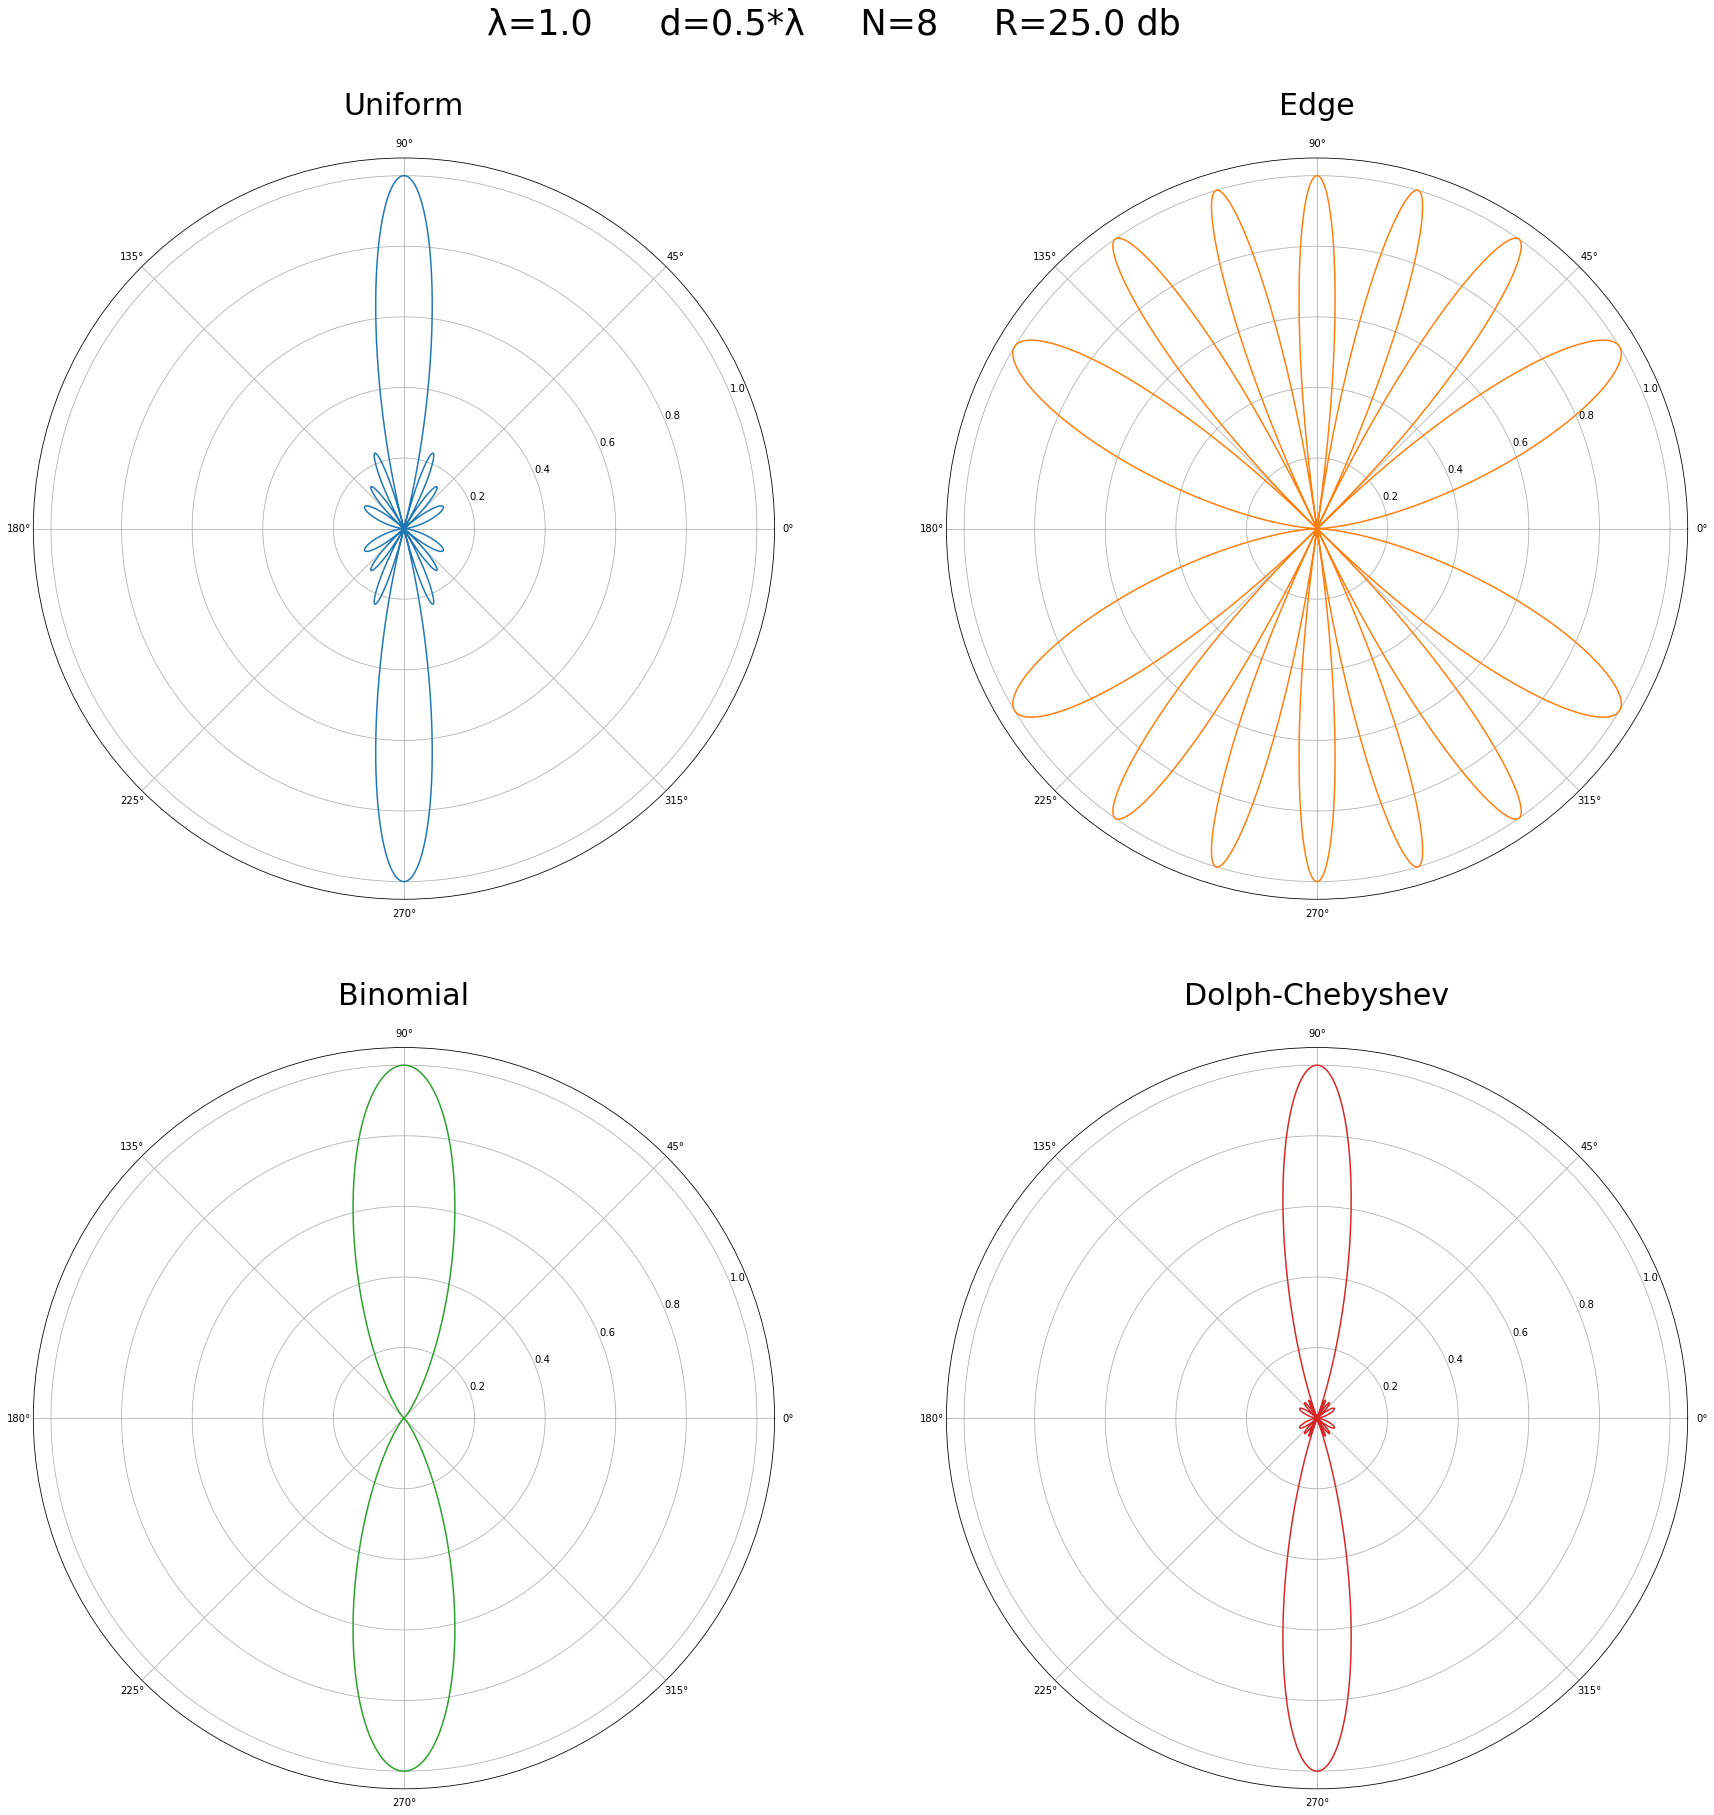

In [27]:
main()

Enter value of λ: 1
Enter d in terms of λ: 1.1
Enter total number of Array Elements: 11
Enter desired Major to minor lobe ratio in db: 50


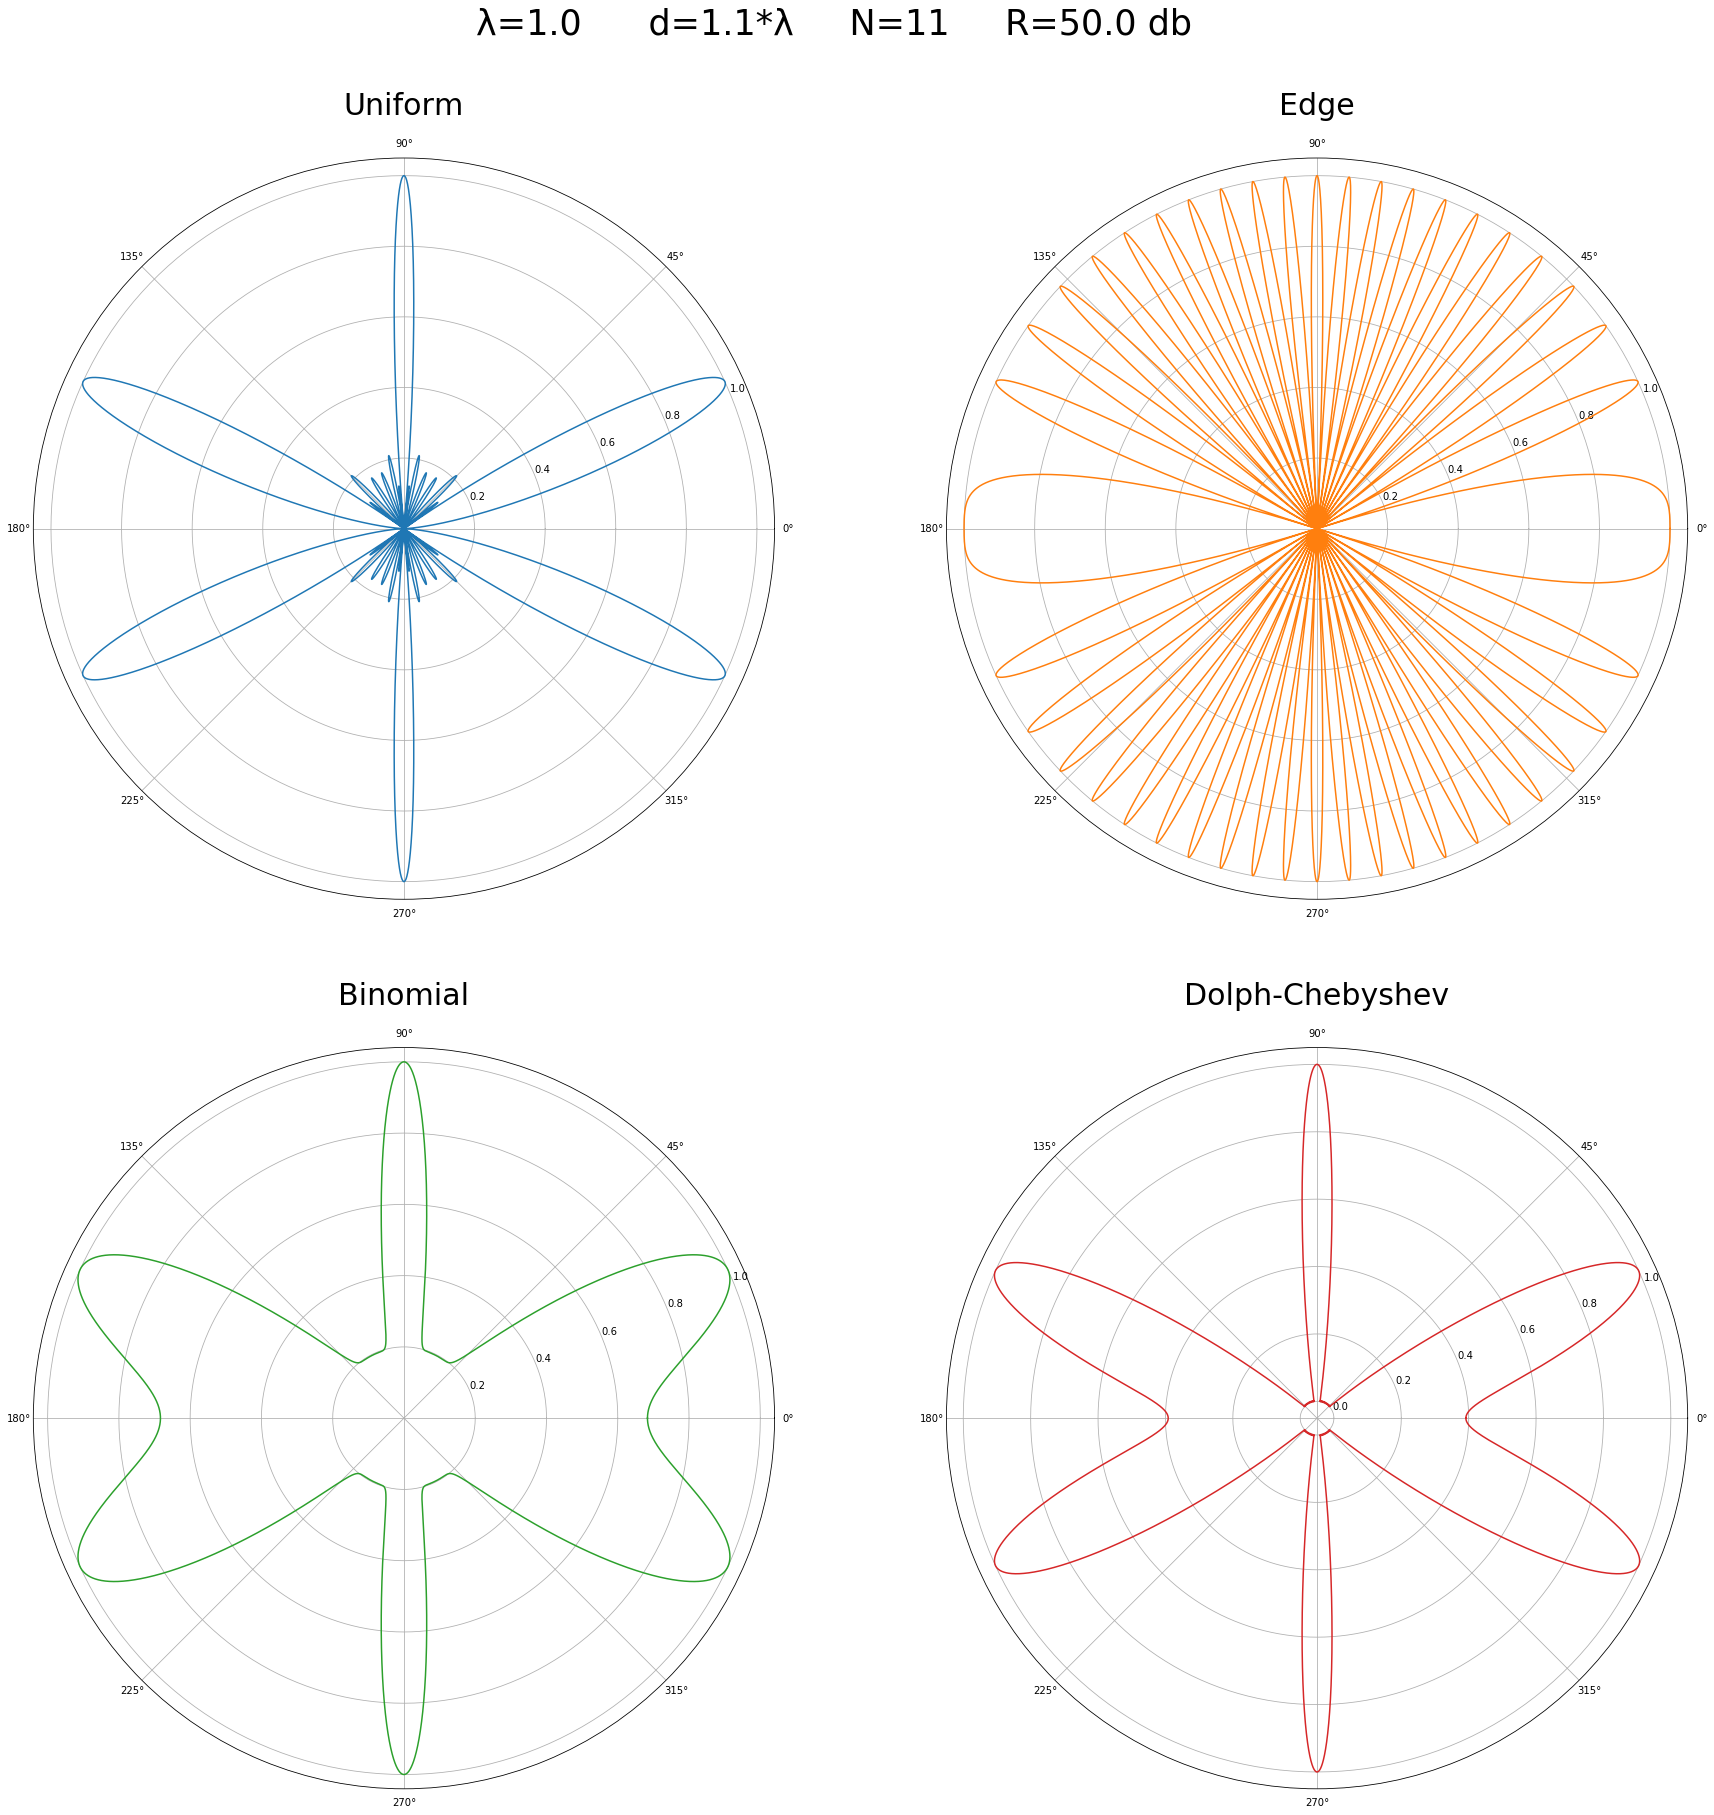

In [28]:
main()